# Introduzione a TensorFlow - parte seconda

In [20]:
from IPython.display import Image
%matplotlib inline

## Costruire una NN con TensorFlow e Keras

Dopo aver imparato, nella prima parte, ad usare i **tensori** e le **pipeline** ed a **caricare i dataset** di TensorFlow possiamo ora cominciare a costruire i primi modelli.<br>
Poichè *TensorFlow* è un pò più flessibile di *scikit-learn*, ma anche più complesso, è meglio cominciare costruendo <u>un semplice modello di regressione</u>.

### l'API di TensorFlow *Keras* (*tf.keras*)
* *Keras* è un'API di alto livello per costruire NN che si appoggia su altre librerie (*low-level*) come TensorFlow, PyTorch e Theano; vedi [qui](https://keras.io/)<br><br>
* *Keras* fornisce <u>un'interfaccia di programmazione facile da usare e modulare</u>, che permette di fare *rapid prototyping* e costruire NN anche complesse con **poche linee di codice**;<br><br>
* *Keras* può essere installata indipendentemente da python e poi configurata con TensorFlow come suo motore di back-end;<br><br>
* *Keras* è fortemente **integrata** con TensorFlow ed i suoi moduli sono accessibili tramite *tf.keras*;<br><br>
* <u>Con TensorFlow 2, *Keras* è diventata l'approccio principale e raccomandato per costruire modelli di ML/DL con TensorFlow</u>;<br><br>
* *Keras* supporta anche funzionalità specifiche di TensorFlow come le pipeline (usando *tf.data*);<br><br>
* <u>in questo corso</u>, per costruire le varie NN useremo *tf.keras*, che rende la costruzione di una rete neurale molto semplice, come vedremo;<br><br>
* il modo più usato per costruire una NN (con *tf.keras*) è la classe ***tf.keras.Sequential()***, che costruisce direttamente uno <u>stack di layer</u> nel modello;<br><br>
* alternativamente, i layer della NN possono essere aggiunti al modello **uno ad uno** con il metodo *.add*;<br><br>
* inoltre, *tf.keras* permette di definire modelli col *subclassing* di un altro modello *tf.keras*; ciò dà più controllo sulla costruzione;<br><br>
* con ***TensorBoard*** è possibile monitorare, anche graficamente, l'avanzamento del training della rete;<br><br>
* infine, i modelli costruiti on l'API *tf.keras* possono essere **compilati ed allenati** con i metodi *.compile()* e *.fit()*.

### Costruire un modello di regressione lineare
Con *TensorFlow / keras*.<br>
Non è una rete!

In [21]:
# creiamo un dataset giocattolo con numpy:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

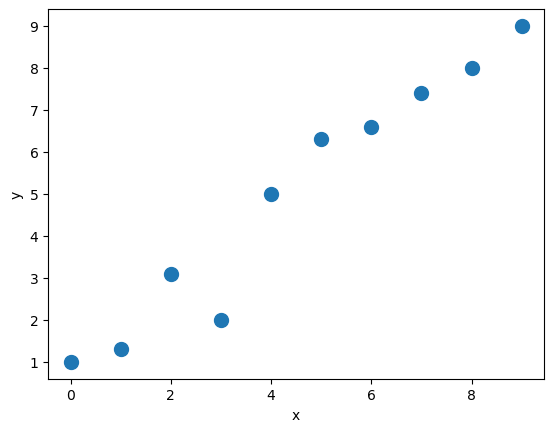

In [22]:
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,
                    2.0, 5.0, 6.3,
                    6.6, 7.4, 8.0,
                    9.0])


plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [23]:
# standardizzazione delle feature (non di y):
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)
# y_train_norm = (y_train - np.mean(y_train))/np.std(y_train)  NON necessario

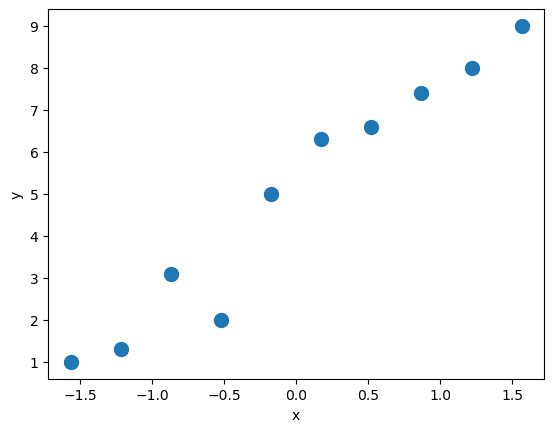

In [24]:
# plot delle feature standardizzate:
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [25]:
# creazione del dataset TensorFlow:
ds_train_orig = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm,tf.float32),
     tf.cast(y_train,tf.float32)))

Ora possiamo creare il modello di regressione lineare *z = wx + b* <u>da zero</u>.<br>
[tf.keras permette anche di costruire modelli con livelli pre-definiti (vedi più avanti)].<br>
Usiamo il metodo del **subclassing** (di *tf.keras.Model*), per poter utilizzare tutte le funzioni keras di costruzione, 
allenamento e valutazione di modelli: *.build*, *.summary*, *.compile*, *.fit*, *.save*, *.evaluate*, ecc.

In [26]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.w = tf.Variable(0.0, name='weight')
        self.b = tf.Variable(0.0, name='bias')

    def call(self, x):
        return self.w*x + self.b

# l'istanziazione di un nuovo modello della classe (che potremo allenare):
model = MyModel()

model.build(input_shape=(None, 1)) # necessario specificare la dimensione dell'input al modello (il numero di feature).
                                   # 'None' è un placeholder per la prima dimensione del tensore di input.

                                   # l'argomento 'input_shape' è dunque il modo per specificare la shape del tensore,
                                   # cioè il numero di componenti (di una certa dimensione).
    
model.summary()                    # un comodo metodo keras di sintesi del modello, layer per layer, con i parametri 
                                   # di ogni layer.

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Un'alternativa alla `model.summary` di *keras* è la `visualkeras`. Vedi [questo post](https://www.linkedin.com/posts/banias_do-you-want-some-cool-visualization-for-your-activity-7235194580365672448-eIwD?utm_source=share&utm_medium=member_desktop).<br>
![](visualkeras.png)

In [27]:
# definiamo la loss function (l'MSE), alla quale applicheremo poi l'algoritmo del SGD.
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


## piccolo test della funzione:
yt = tf.convert_to_tensor([1.0])
yp = tf.convert_to_tensor([1.5])

loss_fn(yt, yp)   # giusto (0.25)

<tf.Tensor: shape=(), dtype=float32, numpy=0.25>

Fittiamo il modello istanziato prima con il metodo **.compile()** ed il metodo **.fit()**.<br>
In TensorFlow si **compila il grafo computazionale che opera sui tensori. Serve un compilatore di algebra lineare**.

In [28]:
tf.random.set_seed(1)  # imposta il seme! [esiste anche una funzione analoga in 'numpy']
num_epochs = 200
batch_size = 1
model.compile(optimizer='sgd', 
              loss=loss_fn,             # la loss function è utilizzata dall'ottimizzatore durante il TRAINING
              metrics=['mae', 'mse'])   # <-- queste sono le metriche (che scegliamo) per valutare le prestazioni di test
model.fit(X_train_norm, y_train, 
          epochs=num_epochs, batch_size=batch_size,verbose=10)
                     # --> vediamo come dall'epoca 1 alla 200 loss, mae ed mse scendano molto: 
                     #     epoca 1:   loss: 27.8723 - mae: 4.5654 - mse: 27.8723  (è un MSE di training, infatti coincide
                     #                                                             con la loss function)
                     #     epoca 200: loss: 0.4138 - mae: 0.4868 - mse: 0.4138
                     #     NB. Solo alla prima esecuzione; alla seconda c'è riuso dei parametri ottimali.
                    
                     # --> verbose = 0: niente
                     #     verbose = 1: tracciamento epoca, ,loss, mae e mse
                     #     verbose = 2: come 1 + ms/step
                     #     verbose = 3: solo l'epoca
                     #     verbose = 4: come 3

Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/200
Epoch 77/200
Epoch 78

**Nota sull'argomento *verbose*** di molte classi di *scikit-learn* e di *keras*:
* se l'argomento è presente, serve a produrre il **LOG** delle attività eseguite dal metodo della classe;
* il log è sullo **standard output** (normalmente il monitor);
* utile in fase di debug;
* tener presente che rallenta, a volte di molto, l'esecuzione;
* il numero di livelli ed il loro significato <u>non è purtroppo documentato</u> da nessuna parte (se non nel codice sorgente del metodo!);
* in genere, sono al massimo implementati i primi 3 livelli; 
* il livello 0 significa *no logging*; il significato degli altri livelli è da scoprire (non è necessariamente un arricchimento progressivo di informazioni loggate)

Vedi anche [questo](https://stackoverflow.com/questions/29995249/verbose-argument-in-scikit-learn) post.

La <u>sequenza</u> di operazioni è quindi: 
* costruzione del modello (con il metodo ***build***), 
* compilazione del modello (con il metodo ***compile***),
* e quindi ***fit*** del modello (con l'analogo metodo). 

2.7067394 4.9657216


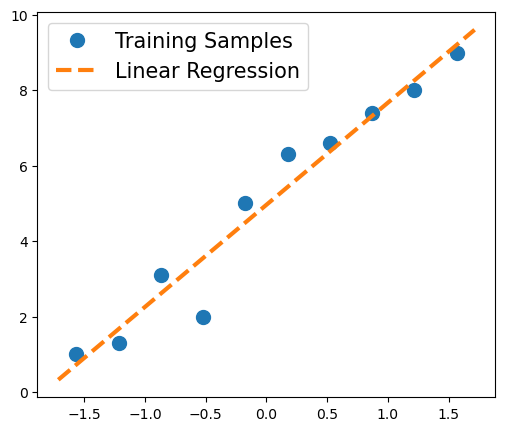

In [29]:
print(model.w.numpy(), model.b.numpy())              # la visualizzazione dei valori FINALI dei due parametri w e b. 
                                                     # è ottenibile applicando la funzione 'numpy' a 'model.x'.
                                                     # sono riferiti ai dati non-standardizzati?

# come test dataset, creiamo un'array numpy di valori equidistanti tra 0 e 9.
X_test = np.linspace(0, 9, num=100).reshape(-1, 1)   # so 18691084 per il significato di reshape (-1,1)

# poichè abbiamo allenato il modello con X standardizzate, dobbiamo standardizzare anche le X di test, ovviamente.
X_test_norm = (X_test - np.mean(X_test)) / np.std(X_test)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5));
ax = fig.add_subplot(1, 2, 1);
plt.plot(X_train_norm, y_train, 'o', markersize=10);                # plot dei dati di training
plt.plot(X_test_norm, y_pred, '--', lw=3);                          # plot della retta di regressione 
                                                                    # (qui visualizzata non tramite i coefficienti, ma tramite
                                                                    # i punti di test e le corrispondenti y previste, calcolate
                                                                    # infatti dalla retta di regressione)
plt.legend(['Training Samples', 'Linear Regression'], fontsize=15);


### Costruire un *multilayer perceptron* per classificare i fiori di *iris*
Nell'esempio precedente abbiamo costruito il modello da **zero**, per <u>imparare</u>. Ma TensorFlow fornisce dei **layer predefiniti** (*tf.keras.layers*) che possono essere impiegati immediatamente come **elementi costitutivi** di un modello di NN, in questo modo semplificando ed efficientando la costruzione del modello stesso.<br><br> 
In questa sezione costruiremo un <u>percettrone a due livelli</u> per classificare *iris*.<br><br>
Questa rete NON usa ancora livelli convolutivi / pooling perchè l'input (i fiori di iris) è strutturato (righe di una tabella a colonne) e dunque è sufficiente una rete MLP tradizionale (pienamente connessa).<br><br>
Questo classificatore è implementato, a titolo di esempio propedeutico, con TF/keras; ma avevamo visto nelle giornate precedenti un analogo classificatore (sempre dei fiori di iris) costruito con la classe *MLPClassifier* di *scikit-learn*.<br><br>
*scikit-learn* è ovviamente più facile da usare di TF/keras. Questo esempio in TF/keras è solo dimostrativo e propededutico all'uso di TK/kears per le CNN (non facilmente modellabili con *scikit-learn*.

In [30]:
# estrazione dei dati:
import tensorflow_datasets as tfds                   # prima fare 'pip install tensorflow_datasets' da un prompt anaconda.
iris, iris_info = tfds.load('iris', with_info=True)  # load del dataset predefinito con il secondo dei due modi possibili.
print(iris_info)                                     # --> info descrittive del dataset.
                                                     #     il dataset è scaricato nella directory 'tensorflow_datasets'.

2.0.0
Using C:\Users\Utente\tensorflow_datasets\iris\2.1.0 instead.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Utente\tensorflow_datasets\iris\2.1.0.incompleteXF7FXF\iris-train.tfrecord*...:   0%|      …

Dataset iris downloaded and prepared to C:\Users\Utente\tensorflow_datasets\iris\2.1.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='iris',
    full_name='iris/2.1.0',
    description="""
    This is perhaps the best known database to be found in the pattern recognition
    literature. Fisher's paper is a classic in the field and is referenced
    frequently to this day. (See Duda & Hart, for example.) The data set contains
    3 classes of 50 instances each, where each class refers to a type of iris
    plant. One class is linearly separable from the other 2; the latter are NOT
    linearly separable from each other.
    """,
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    data_dir='C:\\Users\\Utente\\tensorflow_datasets\\iris\\2.1.0',
    file_format=tfrecord,
    download_size=3.65 KiB,
    dataset_size=7.62 KiB,
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=float32),
        'label': ClassLabel(shape=(), dtype=i

In [31]:
# rimescolamento (shuffle) e partizionamento in training e test (il dataset originario ha una sola partizione, "train",
# vedi la chiave "splits").
tf.random.set_seed(1)

# primo approccio:
# ds_orig = iris['train']                                         # il dataset intero (150 osservazioni)
# ds_orig = ds_orig.shuffle(150, reshuffle_each_iteration=False)  # il secondo argomento evita di mescolare training e test. 
# print(next(iter(ds_orig)))

# approccio alternativo (preferibile?!): 
ds_orig = iris['train']
ds_train_orig = ds_orig.take(100) # caricamento dell'intero dataset
ds_test = ds_orig.skip(100)       # suddivisione in training (100 oss.) e test (le rimanenti 50)

In [32]:
print(type(ds_train_orig))
print(type(ds_train_orig))
                                  # --> un data-type non facilmente ispezionabile (ad es. non c'è un metodo 'shape')

<class 'tensorflow.python.data.ops.take_op._TakeDataset'>
<class 'tensorflow.python.data.ops.take_op._TakeDataset'>


In [33]:
# verifica del numero delle osservazioni:
n = 0
for example in ds_train_orig:
    n += 1
print(n)

n = 0
for example in ds_test:
    n += 1
print(n)
                      # --> ok!

100
50


In [34]:
# conversione da dizionario (un formato proprio di TF con molti metadati anche descrittivi) a tupla (un'istanza, cioè una
# riga di una tabella oppure, in questo caso, una singola immagine) sia per il training che per il test dataset):
ds_train_orig = ds_train_orig.map(
    lambda x: (x['features'], x['label']))

ds_test = ds_test.map(
    lambda x: (x['features'], x['label']))

next(iter(ds_train_orig))

(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([5.1, 3.4, 1.5, 0.2], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>)

In [35]:
# DOPO la conversione in tupla, la verifica delle dimensioni dei due dataset (training e test) può essere fatta
# nel seguente modo:
labels_train = []
for i,item in enumerate(ds_train_orig):
    labels_train.append(item[1].numpy())
    
labels_test = []
for i,item in enumerate(ds_test):
    labels_test.append(item[1].numpy())
print('Training Set: ',len(labels_train), 'Test Set: ', len(labels_test))
                       # --> Ok (ma lo sapevamo già)

Training Set:  100 Test Set:  50


Ora siamo pronti a creare un modello in modo efficiente.<br><br>
Non usiamo più il metodo *.build* utilizzato prima per costruire il modello di regressione.<br> 
Usiamo ora la classe *tf.keras.Sequential* che permette di **impilare diversi livelli** (layer) keras e costruire così un modello di NN.<br><br>
L'elenco dei livelli keras disponibile è [qui](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers). Alcuni importanti sono:
* class *Activation*: Applies an activation function to an output.
* class *Add*: Layer that adds a list of inputs.
* class *Conv1D*: 1D convolution layer (e.g. temporal convolution).
* class *Conv2D*: 2D convolution layer (e.g. spatial convolution over images).
* class *Dense*: Just your regular densely-connected NN layer.
* class *MaxPooling2D*: Max pooling operation for spatial data (cioè per le immagini)
* class *ReLU*: Rectified Linear Unit activation function.
* ecc

Useremo qui il layer **Dense**, che è chiamato anche layer <u>pienamente connesso</u> (*fully connected - FC*), o layer <u>lineare</u>, che può essere rappresentato da:<br> ***f(wx + b)***<br>dove *x* sono le feature, *w* è la matrice dei pesi (aka, *kernel*), *b* è il vettore dei bias e *f* è la funzione di attivazione.<br><br>
Nelle NN ciascun layer riceve gli input dal layer precedente; pertanto, la sua dimensionalità (rango e forma) è fissa. In genere, vogliamo occuparci della dimensione della rete solo nella fase della sua progettazione. Il primo livello è un'eccezione, ma con TensorFlow è possibile definire la dimensione del primo layer (i suoi input) dopo aver definito il modello, con la cosiddetta **creazione ritardata delle variabili**. <br>
Qui vogliamo costruire una NN con due livelli nascosti (una scelta progettuale):
* il primo riceve un input di 4 feature e le proietta su 16 neuroni;
* il secondo riceve l'output del primo (dimensione = 16) e lo proietta su 3 neuroni di output, in quanto abbiamo bisogno di tre etichette di classe (*one-hot encoding*).<br>

In [36]:
iris_model = tf.keras.Sequential([                                # la classe 'Sequential' è di fondamentale importanza e 
                                                                  # sta all'inizio della costruzione della rete.
                                                                  # segue infatti l'elenco dei livelli che sono impilati. 
    
    tf.keras.layers.Dense(16, activation='sigmoid', 
                          name='fc1', input_shape=(4,)),          # <-- l'argomento 'input_shape' specifica la dimensione 
                                                                  #     del primo layer.
                                                                  # <-- il nome 'fc1' significa 'fully connected'.
    
    tf.keras.layers.Dense(3, name='fc2', activation='softmax')])  # <-- l'argomento 'units' (non esplicitato qui perchè usato
                                                                  #     in modo posizionale) definisce il numero di output.

In [37]:
iris_model

Ovviamente la rete ha anche un livello di input ed uno di output, che tuttavia non dobbiamo esplicitare (le precedenti definizioni li implicano).

Come detto prima, *Dense* implementa l'operazione: **output = activation(dot(input, kernel) + bias)** dove:
* *activation* è la funzione di attivazione *element-wise* passata dall'argomento *activation*;
* *kernel* è una matrice di pesi creata dal livello (prima chiamata *w* - entrambe le notazioni sono frequenti);
* *bias* è un vettore di bias creato sempre dal livello (solo se l'argomento *use_bias* è *True*).

In [38]:
# Ora la sintesi del modello con il comodo metodo di keras '.summary' che avevamo già usato per il modello di regressione.
iris_model.summary()
                    # --> il primo layer nascosto (fc1) ha 80 parametri.
                    #     Questo numero è infatti dato da: (n.input+1) x n.output, dove 'n.input' è il numero di unità in
                    #     input al layer, ed 'n.output' il numero di UNITA' del LAYER STESSO.
                    #     Infatti, per un layer pienamente e densamente connesso, i parametri da apprendere sono: 
                    #     - la matrice dei pesi w (di dimensione n.input x n.output) --> 16 x 4 = 64
                    #     - ed il vettore dei bias (di dimensione n.output)          --> 16
                    
                    # --> Analogamente il secondo layer nascosto (fc2) ha 51 parametri perchè:
                    #     - la matrice dei pesi w (di dimensione n.input x n.output) --> 3 x 16 = 48
                    #     - il vettore dei bias (di dimensione n.output)             --> 3
                    
                    # Un modellino banale come questo ha già 131 parametri da imparare dai dati!    

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Abbiamo usato come funzione di attivazione **la funzione sigmoide** per il primo layer, e la **softmax** per l'ultimo layer (l'output).<br> La funzione softmax fornisce le **probabilità** delle singole classi.

### Network Visualization
Do you want some cool visualization for your Deep Learning Models?<br>
Try **visualkeras**.<br>
visualkeras **visualizes your keras model** (as **an alternative to model.summary())**.

In [52]:
!pip install visualkeras --user
import visualkeras

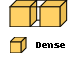

In [53]:
visualkeras.layered_view(iris_model, legend=True)

### La compilazione

Ora **compiliamo** il modello, così come prima avevamo compilato il modello di regressione, specificando la **loss function** (qui, l'entropia), **l'ottimizzatore** (qui, [adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/), che è una estensione molto efficiente di SGD con *learning-rate* adattativo) e la **metrica di valutazione** del modello (qui, *accuracy*).

In [39]:
iris_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

Ora possiamo fittare il modello (cioè *allenarlo*, sinonimo, nel senso che fit è l'esito ed allenamento è il processo).<br>
Usiamo un dataset a ripetizione infinita, che è passato al metodo *fit*.<br>
Affinchè il metodo *fit* possa tener traccia delle epoche, deve conoscere il numero di passi (*step*) di ogni epoca (*steps_per_epoch*).<br>
Su questo aspetto, vedi [questo](https://stackoverflow.com/questions/58842925/when-passing-an-infinitely-repeating-dataset-you-must-specify-the-steps-per-ep) utile post.

In [40]:
num_epochs = 100
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size) # il numero di step per epoca è dato dalla dimensione del dataset di
                                                      # training / la dimensione del batch.

ds_train = ds_train_orig.shuffle(buffer_size=training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size=batch_size)
ds_train = ds_train.prefetch(buffer_size=1000)


history = iris_model.fit(ds_train, epochs=num_epochs,
                         steps_per_epoch=steps_per_epoch, 
                         verbose=0)                   # 'verbose = 0' sopprime gli output intermedi (delle singole epoche)

                                                      # 'verbose = 1  elenca loss ed accuratezza delle varie epoche 
                                                      # (ma DIFFERENTI da quelli estratti dall'oggetto HISTORY, vedi più
                                                      # avanti, che è più affidabile)
                                                      # 'verbose = 2' aggiunge anche i tempi di esecuzione delle epoche
                                                      # 'verbose = 3' elenca solo le epoche (inutile)
    
                                    

In [41]:
type(history)  # un oggetto keras, è la "cronologia" del fit

keras.src.callbacks.History

<u>**Cos'è l'oggetto *history*** prodotto dal metodo *fit*?</u> (vedi anche [qui](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)).<br>
Esso permette di accedere alla <u>cronologia di addestramento</u> del modello Keras.<br><br>
Dobbiamo prima definire cos'è un **callback** (vedi anche [qui](https://keras.io/api/callbacks/)).<br><br>
*A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).<br>
You can use callbacks to*:
* *Write TensorBoard logs after every batch of training to monitor your metrics*
* *Periodically save your model to disk*
* *Do early stopping*
* *Get a view on **internal states and statistics of a model during training**
* *...and more<br>*

*Use callbacks via the built-in fit() loop.<br>
You can pass a list of callbacks (as the keyword argument callbacks) to the .fit() method of a model.*<br><br>
Keras offre la possibilità di registrare i callback durante il training di un modello di deep learning.<br>
Uno dei <u>callback predefiniti</u>, che viene registrato durante l'addestramento di tutti i modelli di deep learning, è il **callback della cronologia**. Esso registra le metriche di addestramento per ogni epoca. Ciò include la perdita (*loss*) e l'accuratezza (per problemi di classificazione), nonché la perdita (*loss*) e l'accuratezza del set di dati di convalida (test), se richiesto.<br><br>

La variabile *history* restituita dal *fit* contiene **la loss** e **l'accuratezza del training** (perchè erano state specificate in input al metodo *compile*) <u>dopo ogni epoca</u>.<br>
Possiamo visualizzare le loro curve rispetto alle 100 epoche:

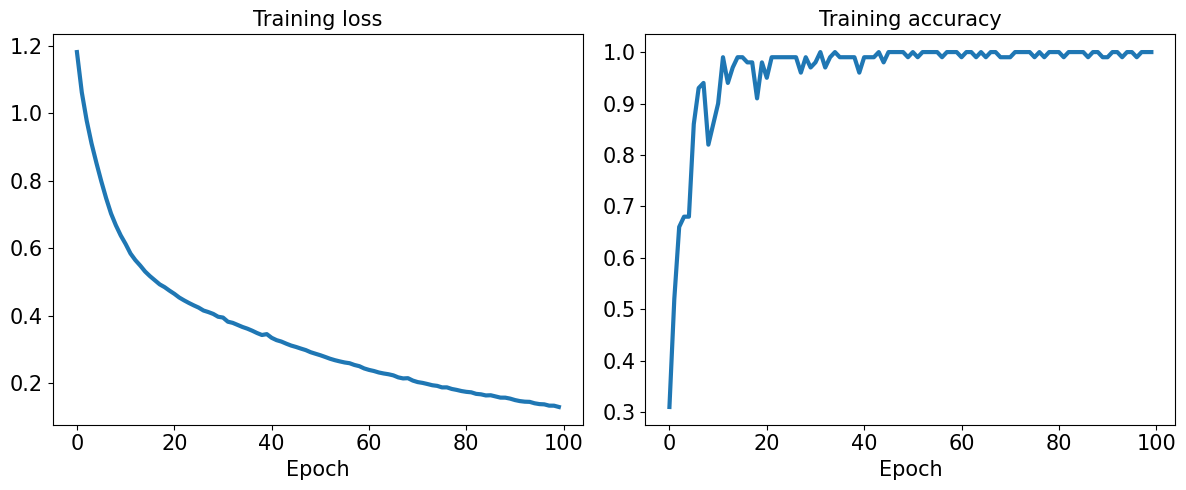

In [42]:
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
#plt.savefig('ch13-cls-learning-curve.pdf')

plt.show()
                    # --> a fine ciclo (delle epoche) l'errore di TRAINING è circa 0 e l'accuratezza di TRAINING 
                    #     è circa il 100%.

In [43]:
# la valutazione del modello prima allenato è fatta ora sui dati di TEST:
results = iris_model.evaluate(ds_test.batch(50), verbose=0)   # dobbiamo trattare in lotti (batch) anche il dataset di test,
                                                              # per assicurarci che l'input al modello abbia il rank 
                                                              # corretto.
                                                              # con l'argomento '.batch(50)', l'intero dataset di test è
                                                              # processato in un lotto (batch) di dimensione 50.
                                                              # se invece usiamo '.batch(1)', allora il dataset di test è
                                                              # processato in 50 batch differenti, ognuno di dimensione 1.
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))
                                                              # --> loss di TEST > 0, accuratezza di TEST: 92% (<100% del
                                                              #     training set)

Test loss: 0.1567   Test Acc.: 0.9400


In [44]:
# salvataggio del modello allenato (per uso futuro). NON voglio dover fittare ogni volta il modello.
# il metodo 'model.save' salva sia l'architettura che i parametri fittati (in formato 'h5' oppure 'tf').
# il metodo 'model.save.weights' salva solo i parametri fittati.
# il metodo 'to_json' salva in formato JSON.

iris_model.save('iris-classifier.h5',     # il filename, 'h5' sta per il formato HDF5, 'tf' per il formato TensorFlow
                overwrite=True,            
                include_optimizer=True,
                save_format='h5')

                                          # --> il metodo '.save' salva su disco nella directory corrente

C:\Users\Utente\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
# ri-caricamento del modello allenato prima salvato.

# vogliamo verificare, per nostra sicurezza, che 1) architettura e 2) risultati siano i medesimi di prima (cioè che save 
# e re-load abbiano funzionato correttamente)

iris_model_new = tf.keras.models.load_model('iris-classifier.h5')

# verifica #1:
iris_model_new.summary() # --> l'architettura è corretta

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
# verifica # 2:
results = iris_model_new.evaluate(ds_test.batch(50), verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))
                          # Ok, l'accuratezza è la medesima di prima.

Test loss: 0.1567   Test Acc.: 0.9400


In [47]:
iris_model_new.to_json() # salvataggio in formato json (sullo standard output)

'{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 4], "dtype": "float32", "sparse": false, "ragged": false, "name": "fc1_input"}, "registered_name": null}, {"module": "keras.layers", "class_name": "Dense", "config": {"name": "fc1", "trainable": true, "dtype": "float32", "batch_input_shape": [null, 4], "units": 16, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "registered_name": null, "build_config": {"input_shape": [null, 4]}}, {"module": "keras.layers", "class_name": "Dense", "config": 

### Monitorare il training con *TensorBoard*
Nell'apprendimento automatico, per migliorare qualcosa è spesso necessario essere in grado di **misurarlo**. *TensorBoard* è uno strumento per fornire <u>le misurazioni e le visualizzazioni</u> necessarie durante il flusso di lavoro di apprendimento automatico (il *learning*). Consente di monitorare varie **metriche** degli esperimenti, quali:
* la perdita (*loss*)  e l'accuratezza (*accuracy*) - [[*loss* vs *accuracy*]](https://stackoverflow.com/questions/34518656/how-to-interpret-loss-and-accuracy-for-a-machine-learning-model)
* la visualizzazione del **grafico** del modello, 
* la proiezione di incorporamenti (*embedding*) in uno spazio dimensionale inferiore e molto altro.

In [49]:
# caricamento della estensione TensorBoard per notebook:
%load_ext tensorboard            # questo comando "magic" carica l'estensione TensorBoard.
                                 # si può eseguire lo stesso comando da prompt anaconda (senza %, ovviamente)

ModuleNotFoundError: No module named 'tensorboard            # questo comando "magic" carica l\'estensione TensorBoard'

In [13]:
import tensorflow as tf
import datetime

In [31]:
# cancellazione della precedente directory di log (e del suo contenuto eventuale)
# [in proposito vedi anche "https://linuxize.com/post/python-delete-files-and-directories/"].
import shutil
dir_path = './logs/'
try:
    shutil.rmtree(dir_path)
except OSError as e:
    print("Error: %s : %s" % (dir_path, e.strerror))

Error: ./logs/ : Impossibile trovare il percorso specificato


Per semplicità, costruiamo lo stesso modello di prima sulla stessa rete, per poter così apprezzare meglio *TensorBoard*.

In [32]:
iris_model = tf.keras.Sequential([                                 
    tf.keras.layers.Dense(16, activation='sigmoid', 
                          name='fc1', input_shape=(4,)),          
    tf.keras.layers.Dense(3, name='fc2', activation='softmax')])  
iris_model.summary()
iris_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
num_epochs = 100
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size) # il numero di step per epoca è dato dalla dimensione del dataset di
                                                      # training / la dimensione del batch.

ds_train = ds_train_orig.shuffle(buffer_size=training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size=batch_size)
ds_train = ds_train.prefetch(buffer_size=1000)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


Durante l'allenamento della rete con *Model.fit()* di Keras, l'aggiunta del *tf.keras.callbacks.TensorBoardcallback* assicura che i registri vengano creati e archiviati. Inoltre, abilita il calcolo dell'istogramma di ogni epoca con *histogram_freq=1* (che è disattivato per impostazione predefinita).<br><br>
E' utile salvare i registri in una sottodirectory con il *timestamp* per consentire poi una facile selezione delle diverse sessioni di allenamento.

In [33]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [34]:
history = iris_model.fit(ds_train, epochs=num_epochs,
                         steps_per_epoch=steps_per_epoch, 
                         callbacks=[tensorboard_callback],
                         verbose=0)  

In [35]:
%tensorboard --logdir logs/fit   # questo comando "magic" attiva TensorBoard.
                                 # si può eseguire lo stesso comando da prompt anaconda (senza %, ovviamente)

Reusing TensorBoard on port 6006 (pid 14672), started 0:07:45 ago. (Use '!kill 14672' to kill it.)

Una breve **panoramica** delle dashboard visualizzate (i *tab* nella barra di navigazione in alto):
* il dashboard *Scalars* mostra come la perdita (*loss*) e le metriche cambiano ad ogni epoca. Si può usare anche per monitorare la velocità di allenamento (*training*), la velocità di apprendimento (*learning*) ed altri valori scalari.
* la dashboard *Graphs* aiuta a visualizzare il modello. In questo caso, viene mostrato il grafico dei livelli *Keras*, come verifica che il modello sia costruito correttamente.
* i dashboard *Distributions* e *Hist(ograms)* mostrano la distribuzione di un tensore nel tempo. Ciò può essere utile per visualizzare pesi e bias e verificare che stiano cambiando nel modo previsto.<br>

Ulteriori plug-in TensorBoard sono abilitati automaticamente se si registrano altri tipi di dati. Ad esempio, il *callback Keras TensorBoard* permette di registrare anche immagini e incorporamenti vari (*embedding*). La lista dei plugin disponibili in TensorBoard è visibile facendo clic sul menu a discesa "inactive" in alto a destra.

## Sinossi delle funzioni di attivazione per NN multilayer

Sinora in questo corso per semplicità abbiamo usato solo la funzione di attivazione **logistica** (aka, *sigmoidale*).<br>
[*Pro-memoria*: anche nella costruzione del modello MLP (nella giornata precedente del corso) con la classe *MLPClassifier* di *scikit-learn* avevamo usato la funzione logistica per il livello nascosto].<br><br> 
La funzione di attivazione logistica è molto usata nel ML/DL, ma <u>non è certo l'unica</u>.<br><br>
Esistono <u>molte funzioni di attivazione</u>: in linea di principio, l'unico requisito di una funzione di attivazione (per allenare una rete multi-livello) è che sia **differenziabile**.<br><br>
Non confondere la funzione di attivazione, che è **dentro** il modello, con la *loss function*, che opera **a valle** del modello. La loss function, come visto nelle scorse giornate, può anche essere non-differenziabile (ad es. la *hinge loss* degli SVM), comunque trattabile con il metodo del **sub**-gradiente perchè *convessa*.<br><br>
Possiamo anche usare funzioni di attivazione **lineari** (come ad esempio nell'*Adaline*, come visto).<br><br>
Tuttavia, in pratica, non è consigliabile usare una funzione di attivazione lineare sia per i livelli nascosti che per quello di output, perchè in genere si vuole introdurre della **non-linearità** nel modello per <u>permettergli di fittare problemi più complessi</u>.<br><br>
La funzione di attivazione logistica è stata la prima ad essere usata per allenare reti neurali, anche probabilmente perchè simula (in modo molto debole, comunque) il funzionamento del neurone biologico.<br><br>
 Per una scelta della funzione di attivazione vedi anche [qui](https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/#:~:text=An%20activation%20function%20in%20a,a%20layer%20of%20the%20network).

**La funzione di attivazione fa parte del modello e dunque contribuisce a calcolare la Y prevista; ecco perchè impatta sul tipo di *Decision Boundary* prodotto dal classificatore (ad es. non-lineare).**

### Ripasso della funzione Logistica
Usiamo un esempio concreto: un modello per dati bi-variati con i seguenti coefficienti *w*:

In [6]:
import numpy as np

X = np.array([1, 1.4, 2.5]) ## first value must be 1
w = np.array([0.4, 0.3, 0.5])

def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print('P(y=1|x) = %.3f' % logistic_activation(X, w)) 
                  # --> probabilità 88% che l'osservazione x appartenga alla classe positiva.

P(y=1|x) = 0.888


In [7]:
z = np.arange(-5, 5, 0.005)
from scipy.special import expit

expit(z)                       # l'implementazione scipy della funzione logistica (per i net input sopra definiti con 
                               # np.arange).

array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])

In [8]:
tf.keras.activations.sigmoid(z) # l'implementazione keras della funzione logistica (per i net input sopra definiti).
                               # si ottengono gli stessi valori di scipy, ovviamente.

<tf.Tensor: shape=(2000,), dtype=float64, numpy=
array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])>

Il seguente esempio mostra come un livello di output formato da funzioni di attivazione logistiche NON fornisce risultati interpretabili come probabilità di classe.

In [9]:
# W : array with shape = (n_output_units, n_hidden_units+1)
# note that the first column are the bias units

W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

# A : data array with shape = (n_hidden_units + 1, n_samples)
# note that the first column of this array must be 1

A = np.array([[1, 0.1, 0.4, 0.6]])
Z = np.dot(W, A[0])
y_probas = logistic(Z)
print('Net Input: \n', Z)

print('Output Units:\n', y_probas) 
      # --> i tre output non sommano ad 1.

Net Input: 
 [1.78 0.76 1.65]
Output Units:
 [0.85569687 0.68135373 0.83889105]


Questo non è un problema se vogliamo prevedere in output **solo la classe** (e non la probabilità di classe). E' infatti sufficiente usare il <u>valore massimo</u>:

In [10]:
y_class = np.argmax(Z, axis=0)
print('Predicted class label: %d' % y_class) 

Predicted class label: 0


### Stimare le probabilità di classe (se *k>2*) con la funzione *softmax*
Come sappiamo, nel caso di problemi di classificazione multi-classe (cioè, *k > 2*) nei quali si voglia in output la <u>probabilità delle singole classi</u>, come funzione di attivazione del livello di output si usa la funzione **softmax**. 

In [46]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

y_probas = softmax(Z)
print('Probabilities:\n', y_probas)

np.sum(y_probas)

Probabilities:
 [0.44668973 0.16107406 0.39223621]


1.0

In [47]:
import tensorflow as tf

Z_tensor = tf.expand_dims(Z, axis=0)
tf.keras.activations.softmax(Z_tensor)

<tf.Tensor: shape=(1, 3), dtype=float64, numpy=array([[0.44668973, 0.16107406, 0.39223621]])>

### Allargare lo spettro dei valori di output con la *tangente iperbolica*
La funzione logistica, tuttavia, ha un **problema**: se l'input *z* è fortemente negativo, l'output della funzione logistica è molto vicino a 0, e quindi la rete impara lentamente e l'ottimizzatore (durante l'addestramento della rete) più facilmente rimane bloccato in un minimo locale.<br><br>
Questo è il motivo per il quale spesso si preferisce usare, come funzione di attivazione dei livelli nascosti, la **tangente iperbolica**, in genere detta per semplicità **tanh**. E' una funzione logistica *ri-scalata*.

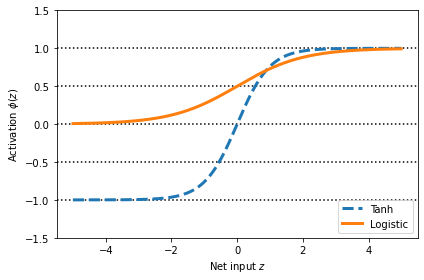

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

# l'implementazione della tanh in 'numpy':
def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel('Net input $z$')
plt.ylabel('Activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(z, tanh_act,
    linewidth=3, linestyle='--',
    label='Tanh')
plt.plot(z, log_act,
    linewidth=3,
    label='Logistic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
                           # --> come si vede, le forme delle due funzioni sono simili, ma la 'tanh' ha uno spettro di 
                           #     valori di output più ampio: [-1,1] anzichè solo [0,1].

In [49]:
np.tanh(z)                      # l'implementazione numpy della tanh (per i net input sopra calcolati)

array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])

In [50]:
import tensorflow as tf

tf.keras.activations.tanh(z)    # l'implementazione TensorFlow della tanh (per i net input sopra calcolati).
                                # si ottengono gli stessi valori di numpy, ovviamente.

<tf.Tensor: shape=(2000,), dtype=float64, numpy=
array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])>

### La funzione di attivazione *Rectified linear unit (ReLU)*
La **ReLU** è un'altra funzione di attivazione che viene spesso utilizzata nelle NN profonde.<br><br> 
Prima di approfondire la ReLU, dobbiamo fare un passo indietro e comprendere il problema della **scomparsa del gradiente** (*vanishing gradient*) della funzione *tanh* e delle attivazioni logistiche. Assumiamo di avere inizialmente l'input netto *z1 = 20*, che cambia poi in *z2 = 25*. Calcolando l'attivazione *tanh*, otteniamo *phi(z1) = 1* e *phi(z2) = 1* (cioè, nessun cambiamento nell'output a causa del comportamento asintotico di *tanh* e degli errori numerici).<br><br>
<u>Ciò significa che la derivata delle attivazioni rispetto al *net input* diminuisce all'aumentare di *z*</u>. Di conseguenza, l'apprendimento dei pesi (durante la fase di allenamento della rete) diventa **molto lento** perché le componenti del gradiente possono essere molto vicine allo zero. L'attivazione *ReLU* risolve questo problema.<br><br>
Matematicamente, *ReLU* è così definita: *phi(z) = maz(0,z)*.<br><br>
*ReLU* è ancora una funzione <u>non lineare</u>; è utile per l'apprendimento di **funzioni complesse** con NN. Inoltre, la derivata di *ReLU*, rispetto al suo input, è sempre 1 per valori di input positivi. Pertanto, *ReLu* risolve il problema della scomparsa del gradiente ed è quindi adatta a NN profonde.<br><br>
In TensorFlow, possiamo applicare l'attivazione *ReLU* in questo modo:

In [52]:
import tensorflow as tf

tf.keras.activations.relu(z)

<tf.Tensor: shape=(2000,), dtype=float64, numpy=array([0.   , 0.   , 0.   , ..., 4.985, 4.99 , 4.995])>

Più avanti, useremo la funzione di attivazione *ReLU* come funzione di attivazione per **NN convoluzionali multilivello**.<br><br>
Concludiamo con una **panoramica** delle diverse funzioni di attivazione finora trattate.

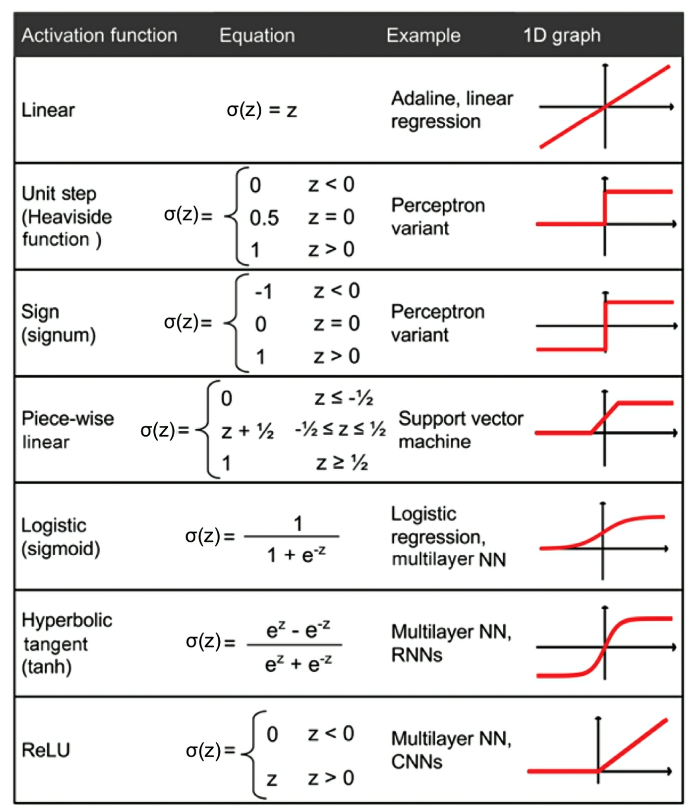

In [87]:
Image(filename='./images/activation_function_summary.png', width=600) # --> sinossi delle funzioni di attivazione.
                                                               #     la piece-wise linear è anche detta hinge loss
                                                               #     (vedi il post cross-validated 372999).  

**Da *Wikipedia EN***:<br><br>
In artificial neural networks, each neuron forms a weighted sum of its inputs and passes the resulting scalar value through a function referred to as an **activation function or transfer function**. If a neuron has n inputs {x1,x2,...xn} then the output or activation of a neuron is *a=g(w1x1+w2x2+w3x3+...wnxn+b)*.<br><br>
This function *g* is referred to as the activation function. <br><br>
If the function *g* is taken as the linear function *g(z)=z* then the neuron performs **linear regression or classification**.<br><br>
In general *g* is taken to be a **nonlinear function** to do nonlinear regression and solve classification problems that are not linearly separable.<br><br>
When *g* is taken to be a **sigmoidal** or 's' shaped function varying from 0 to 1 or -1 to 1, the output value of the neuron can be interpreted as a YES/NO answer or binary decision.<br><br>
However [**saturating activation function**](https://stats.stackexchange.com/questions/174295/what-does-the-term-saturating-nonlinearities-mean) can cause the **vanishing gradient problem** in deep networks. Replacing saturating sigmoidal activation functions with activation functions like **ReLU** that have larger derivative values allowed deeper networks to be trained for the first time.<br><br>
Non-monotonic and oscillating activation functions that significantly outperform ReLU have since been found.In particular oscillating activation functions improve gradient flow, speedup training and allow single neurons to learn the XOR function like certain human cerebral neurons.

## Sintesi
*TensorFlow* è più complesso da usare di *numpy* ma permette di allenare grandi reti multi-livello in modo molto efficiente.<br><br>
Inoltre, *TensorFlow* supporta le **GPU**.<br><br>
Abbiamo creato e manipolato i *tensori*.<br><br>
Abbiamo usato l'API di *TensorFlow Dataset* per costruire **data pipeline** di pre-processing (*tf.data*).<br><br>
Abbiamo realizzato una rete da zero (tramite il *subclassing* di *tf.keras.Model*) e poi usando i livelli pre-definiti (tramite *tf.keras.layers*).<br><br>
Abbiamo quindi approfondito l'importante tema delle funzioni di attivazione.<br><br>

# *Recap* dell'API di *keras*
Recap degli step base per costruire un modello NN *feed-forward, fully connected*, tramite una serie di layer impilati con la classe *Sequential()* di *keras*.<br><br>
Nell'esempio seguente, costruiamo due livelli *densamente* (cioè, pienamente) connessi.

In [116]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))

## late variable creation
model.build(input_shape=(None, 4))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                80        
                                                                 
 dense_5 (Dense)             (None, 32)                544       
                                                                 
Total params: 624
Trainable params: 624
Non-trainable params: 0
_________________________________________________________________


Abbiamo specificato la *input_shape* con *model.build*, instanziando le variabili DOPO aver definito il modello di quella specifica forma (*shape*).<br><br>
I parametri (**le variabili!**) dei livelli sono: *16x4 + 16 = 80* (per il primo) e *16x32 + 32 = 544* (per il secondo).<br><br>
Una volta che i parametri del modello sono stati creati, possiamo accedere sia a quelli allenabili che non, in questo modo:

In [117]:
for v in model.variables:
    print('{:20s}'.format(v.name), v.trainable, v.shape)

dense_4/kernel:0     True (4, 16)
dense_4/bias:0       True (16,)
dense_5/kernel:0     True (16, 32)
dense_5/bias:0       True (32,)


Ogni livello ha una **matrice dei pesi**, anche chiamata *kernel*.<br><br>
[Non confondere questo *kernel* con quello degli SVM ed il filtro delle reti CNN (più avanti). C'è un abuso del termine *kernel*?!]

I livelli possono poi essere **configurati**, applicando differenti **funzioni di attivazione**, differenti **inizializzazioni dei parametri**, e differenti metodi di **regolarizzazione** (per prevenire il rischio di *overfitting*).

 * Keras Initializers `tf.keras.initializers`: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/initializers  
 * Keras Regularizers `tf.keras.regularizers`: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/regularizers  
 * Activations `tf.keras.activations`: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/activations  

In [119]:
# Creazione di una nuova pila e configurazione del primo livello specificando gli inizializzatori della matrice dei pesi 
# e del vettore dei bias.
model = tf.keras.Sequential()

model.add(
    tf.keras.layers.Dense(
        units=16, 
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.GlorotNormal(),
        bias_initializer=tf.keras.initializers.Constant(2.0)
    ))

# Configurazione del secondo livello specificando un regolarizzatore di norma L1 per la matrice dei pesi.

model.add(
    tf.keras.layers.Dense(
        units=32, 
        activation=tf.keras.activations.sigmoid,
        kernel_regularizer=tf.keras.regularizers.l1
    ))

model.build(input_shape=(None, 4))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                80        
                                                                 
 dense_9 (Dense)             (None, 32)                544       
                                                                 
Total params: 624
Trainable params: 624
Non-trainable params: 0
_________________________________________________________________


Oltre a configurare i singoli livelli, possiamo anche configurare **l'intero modello** quando lo compiliamo, specificando il tipo di **ottimizzatore**, la **loss function** del training set e le **metriche di valutazione** delle prestazioni predittive sul test set. 

 * Keras Optimizers `tf.keras.optimizers`:  https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers
 * Keras Loss Functins `tf.keras.losses`: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses
 * Keras Metrics `tf.keras.metrics`: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/metrics

In [120]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),   # ottimizzatore SGD
    loss=tf.keras.losses.BinaryCrossentropy(),                # loss function: cross-entropy
    metrics=[tf.keras.metrics.Accuracy(),                     # 3 metriche di valutazione
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),])

Il metodo *.fit()* restituisce poi la <u>storia (nelle varie epoche)</u> della loss e delle metriche di valutazione nell'oggetto *history*. <br><br>
E' sempre consigliabile dare uno sguardo alla storia dell'allenamento.<br><br>
NB. Una delle differenze principali tra training e previsione è che nella seconda non è richiesto il calcolo del gradiente. Inoltre ci sono certi metodi che si comportano in modo differente a seconda che si sia *training mode* e *prediction mode*. Ad esempio, vedi più avanti il *drop-out*.<br><br>
Quelli prima ricapitolati sono i <u>passi fondamentali</u> per costruire una rete con *TensorFlow/keras*.<br><br>

Quella sinora presentata è l'API di *keras* **object-oriented** (*Sequential()*). E' comoda e molto usata. Tuttavia non permette di creare modelli complessi con  input, output e branch multipli.<br><br>
Esiste un'API **funzionale** di *keras*, che dà più flessibilità e controllo nella creazione dei vari livelli.

Si rimanda ad altri testi / link per la trattazione di concetti di TensorFlow <u>più avanzati</u>, come:
* *function decorators* per migliorare le prestazioni computazionali;
* gli *estimator* per incapsulare gli step di training, previsione e valutazione (utile per costruire un codice scalabile e multi-piattaforma);
* l'API funzionale di *keras*;
* i livelli *custom* (con *tf.keras.layers*).

# L'architettura della rete


In generale, quale **architettura** scegliere?<br><br>
Per fittare un *Decision Boundary* **non-lineare** dobbiamo impilare nella rete uno o più livelli con una funzione di attivazione non-lineare. Esiste infatti un **teorema** (dell'approssimazione universale) che afferma che una rete *feed-forward* con 1 livello nascosto ed un numero sufficientemente grande di nodi (neuroni) può approssimare (fittare) abbastanza bene una qualsiasi funzione continua (la funzione *f* del processo generativo dei dati ed approssimata dalla f.hat fittata dal modello).<br><br>
Una possibile strategia è dunque: mettere nel modello un livello nascosto, con un numero progressivamente maggiore di nodi e confrontare le prestazoni dei vari modelli sul test set.<br><br> 
Tuttavia è meglio mettere nel modello **diversi livelli nascosti**, anzichè 1 solo, con meno nodi. In questo modo la rete è **profonda** anzichè **ampia**. Un modello profondo richiede meno nodi di uno ampio per raggiungere la stessa capacità. Per contro, un modello profondo è più esposto al rischio della scomparsa del gradiente e dunque più difficile da allenare (fittare). In effetti, il limite alla profondità di una rete è proprio dato dal problema della scomparsa del gradinte (*Chollet*).<br><br>
Come <u>regola generale</u>, più sono i livelli e più sono i neuroni (nodi) dei vari livelli, maggiore è la **capacità** adattiva della rete a funzioni anche complesse.<br><br>
Tuttavia, come sappiamo, i modelli complessi sono più difficili da allenare e si prestano maggiormente al rischio di *overfitting*, e da qui la necessità di regolarizzare i modelli complessi o comunque che mostrano di andare facilmente in overfitting.<br><br>
In pratica, **è sempre una buona idea iniziare con una rete semplice, ad esempio di un singolo livello nascosto, con la funzione di attivazione logistica**.

# Appendice

## Suddividere un dataset: il modo giusto ed il modo sbagliato

In [65]:
## the correct way:
ds = tf.data.Dataset.range(15)
ds = ds.shuffle(15, reshuffle_each_iteration=False)


ds_train = ds.take(10)
ds_test = ds.skip(10)

ds_train = ds_train.shuffle(10).repeat(10)
ds_test = ds_test.shuffle(5)
ds_test = ds_test.repeat(10)

set_train = set()
for i,item in enumerate(ds_train):
    set_train.add(item.numpy())

set_test = set()
for i,item in enumerate(ds_test):
    set_test.add(item.numpy())

print(set_train, set_test)

{0, 1, 2, 5, 8, 10, 11, 12, 13, 14} {3, 4, 6, 7, 9}


In [66]:
## The wrong way:
ds = tf.data.Dataset.range(15)
ds = ds.shuffle(15, reshuffle_each_iteration=True)


ds_train = ds.take(10)
ds_test = ds.skip(10)

ds_train = ds_train.shuffle(10).repeat(10)
ds_test = ds_test.shuffle(5)
ds_test = ds_test.repeat(10)

set_train = set()
for i,item in enumerate(ds_train):
    set_train.add(item.numpy())

set_test = set()
for i,item in enumerate(ds_test):
    set_test.add(item.numpy())

print(set_train, set_test)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14} {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}


### Splitting a dataset using `tfds.Split`

In [67]:

##--------------------------- Attention ------------------------##
##                                                              ##
##     Note: currently, tfds.Split has a bug  in TF 2.0.0       ##
##                                                              ##
##  I.e., splitting [2, 1] is expected to result in             ##
##      100 train and 50 test examples                          ##
##                                                              ##
##  but instead, it results in 116 train and 34 test examples   ##
##                                                              ##
##--------------------------------------------------------------##

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

##  method 1: specifying percentage:
#first_67_percent = tfds.Split.TRAIN.subsplit(tfds.percent[:67])
#last_33_percent = tfds.Split.TRAIN.subsplit(tfds.percent[-33:])

#ds_train_orig = tfds.load('iris', split=first_67_percent)
#ds_test = tfds.load('iris', split=last_33_percent)


##  method 2: specifying the weights
split_train, split_test = tfds.Split.TRAIN.subsplit([2, 1])

ds_train_orig = tfds.load('iris', split=split_train)
ds_test = tfds.load('iris', split=split_test)

print(next(iter(ds_train_orig)))
print()
print(next(iter(ds_test)))


ds_train_orig = ds_train_orig.shuffle(100, reshuffle_each_iteration=True)
ds_test  = ds_test.shuffle(50, reshuffle_each_iteration=False)

ds_train_orig = ds_train_orig.map(
    lambda x: (x['features'], x['label']))

ds_test = ds_test.map(
    lambda x: (x['features'], x['label']))

print(next(iter(ds_train_orig)))


for j in range(5):
    labels_train = []
    for i,item in enumerate(ds_train_orig):
        labels_train.append(item[1].numpy())

    labels_test = []
    for i,item in enumerate(ds_test):
        labels_test.append(item[1].numpy())
    print('Training Set: ',len(labels_train), 'Test Set: ', len(labels_test))

    labels_test = np.array(labels_test)

    print(np.sum(labels_test == 0), np.sum(labels_test == 1), np.sum(labels_test == 2))

AttributeError: 'Split' object has no attribute 'subsplit'

<br>
<br>
<br>